In [1]:
import math
import pandas as pd 
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt

import h3 # h3 bins from uber

## Loading helper functions

These functions have been copied over from notebooks that already exist for this project. Ideally, these would be imported from a module.

In [2]:
#Loading the data
def create_crash_df(train_file = '../Inputs/Train.csv'):  
    crash_df = pd.read_csv(train_file, parse_dates=['datetime'])
    return crash_df

#Creating temporal features like months, weekdays, etc.
def create_temporal_features(df):
    dict_windows = {1: "00-03", 2: "03-06", 3: "06-09", 4: "09-12", 5: "12-15", 6: "15-18", 7: "18-21", 8: "21-24"}
    dict_months = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
               7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}
    df["time_window"] = df["datetime"].apply(lambda x: math.floor(x.hour / 3) + 1)
    df["time_window_str"] = df["time_window"].apply(lambda x: dict_windows.get(x))
    df["day"] = df["datetime"].apply(lambda x: x.day)
    df["month"] = df["datetime"].apply(lambda x: dict_months.get(x.month))
    df["year"] = df["datetime"].apply(lambda x: x.year)
    df["weekday"] = df["datetime"].apply(lambda x: x.weekday())
    return df

#Exporting the dataframe back to csv
def export_df_to_csv(df,path_file='../Inputs/train_h3.csv'):
    df.to_csv(path_file,index=False)
    print(f'file created {path_file}') 

#Joins provided data sets for road segments into one file, indicating latitude and longitude for each segment. This enables placement in h3 bins.    
def join_segment_files(path='../Inputs/', road_surveys='Segment_info.csv',segments_geometry='segments_geometry.geojson'):
    ''' 
        Load the survey data, Load the segment geometry, Join the two segment dfs.
        return a combined dataframe
    '''
    road_surveys = pd.read_csv(path+road_surveys)
    road_segment_locs = gpd.read_file(path+segments_geometry)
    segments_merged = pd.merge(road_segment_locs, road_surveys, on='segment_id', how='left')
    segments_merged["longitude"] = segments_merged.geometry.centroid.x
    segments_merged["latitude"] = segments_merged.geometry.centroid.y
    segments_merged = assign_hexbin(segments_merged)
    return segments_merged

#Defines time clusters, see docstring for more info
def assign_TW_cluster(weekday, time_window, holiday=0, strategy='baseline'):
    '''
    Can be used in a lambda function to return the time window cluster for a given day and time window.
    e.g. crash_df["cluster"] = crash_df.apply(lambda x: return_TW_cluster(x.weekday, x.time_window_str) ,axis=1)
    This is called by the function: create_cluster_feature.
    '''
    if strategy == 'baseline':
        return 'baseline'
    
    if strategy == 'mean_shift_modified':
        if weekday == 7:
            return 'off_peak'        
        elif weekday == 6:
            return 'off_peak'
        elif weekday in [0,1,2,3,4]:
            if time_window in ["06-09"]:
                return 'peak'
            elif time_window in ["09-12", "12-15", "15-18", "18-21"]:
                return 'middle'
            elif time_window in ["00-03", "03-06", "21-24"]:
                return 'off_peak'    
        elif weekday == 5:
            if time_window in ["06-09", "12-15", "15-18", "18-21"]:
                return 'middle'
            elif time_window in ["00-03", "03-06", "21-24"]:
                return 'off_peak'
            elif time_window in ["09-12"]:
                return 'peak'
    
    elif strategy == 'saturday_2':
        if weekday == 7:
            return 'off_peak'        
        elif weekday == 6:
            return 'off_peak'
        elif weekday in [0,1,2,3,4]:
            if time_window in ["06-09"]:
                return 'peak'
            elif time_window in ["09-12", "12-15", "15-18", "18-21"]:
                return 'middle'
            elif time_window in ["00-03", "03-06", "21-24"]:
                return 'off_peak'    
        elif weekday == 5:
            if time_window in ["06-09", "12-15", "15-18", "18-21"]:
                return 'saturday_busy'
            elif time_window in ["00-03", "03-06", "21-24"]:
                return 'off_peak'
            elif time_window in ["09-12"]:
                return 'saturday_busy'    
    
    elif strategy == 'holiday_7':
        if weekday == 7:
            return 'holiday'        
        elif weekday == 6:
            return 'sunday'
        elif weekday in [0,1,2,3,4]:
            if time_window in ["06-09"]:
                return 'peak'
            elif time_window in ["09-12", "12-15", "15-18", "18-21"]:
                return 'middle'
            elif time_window in ["00-03", "03-06", "21-24"]:
                return 'off_peak'    
        elif weekday == 5:
            if time_window in ["06-09", "12-15", "15-18", "18-21"]:
                return 'saturday_busy'
            elif time_window in ["00-03", "03-06", "21-24"]:
                return 'off_peak'
            elif time_window in ["09-12"]:
                return 'saturday_busy'      

    elif strategy == 'holiday_7':
        if weekday == 7:
            return 'holiday'        
        elif weekday == 6:
            return 'sunday'
        elif weekday in [0,1,2,3,4]:
            if time_window in ["06-09"]:
                return 'peak'
            elif time_window in ["09-12", "12-15", "15-18", "18-21"]:
                return 'middle'
            elif time_window in ["00-03", "03-06", "21-24"]:
                return 'off_peak'    
        elif weekday == 5:
            if time_window in ["06-09", "12-15", "15-18", "18-21"]:
                return 'saturday_busy'
            elif time_window in ["00-03", "03-06", "21-24"]:
                return 'off_peak'
            elif time_window in ["09-12"]:
                return 'saturday_busy'      
    

    elif strategy == 'no_cluster':
        return (str(weekday)+str(time_window)+str(holiday))

#Creates time cluster feature in existing data frame
def create_cluster_feature(crash_df, strategy='baseline', verbose=0):
    '''
    Function takes crash df and creates new column with tw cluster labels.
    If verbose is increased, the time window clusters will be visualised.
    '''
    crash_df["cluster"] = crash_df.apply(lambda x: 
                                         assign_TW_cluster(weekday=x.weekday,
                                                           time_window=x.time_window_str,
                                                           strategy=strategy) 
                                         ,axis=1)
    
    print(f'{crash_df.cluster.nunique()} clusters created')
    if verbose > 1:
        tb_clusters = sns.FacetGrid(crash_df,hue='cluster', height=5)
        tb_clusters.map(sns.stripplot,'weekday', 'time_window_str', s=20, 
                                       order = ['00-03', '03-06', '06-09', '09-12', 
                                                '12-15', '15-18', '18-21', '21-24'],
                                    label = 'Time Window Clusters')
    return crash_df

## Changes to hexbin function

To have a cleaner dataframe for each iteration of the pipeline, I adapted the functioning for creating hex bins so that it takes the desired resolution of the h3 bins is taken as an argument by the function - default is set to 6. The major difference is that the function does not add 3 columns at once now but only the resolution that is specified.

In [3]:
#Assigning hex bins based on h3 classification and latitude and longitude
def assign_hexbin(df,lat_column="latitude",lon_column="longitude", hexbin_resolution=6):
    df["h3_zone_{}".format(hexbin_resolution)] = df.apply(lambda x: h3.geo_to_h3(x[lat_column], x[lon_column], hexbin_resolution),axis=1)
    return df

# ***Old function below for comparison***
#def assign_hex_bin(df,lat_column="latitude",lon_column="longitude"):
#    df["h3_zone_5"] = df.apply(lambda x: h3.geo_to_h3(x[lat_column], x[lon_column], 5),axis=1)
#    df["h3_zone_6"] = df.apply(lambda x: h3.geo_to_h3(x[lat_column], x[lon_column], 6),axis=1)
#    df["h3_zone_7"] = df.apply(lambda x: h3.geo_to_h3(x[lat_column], x[lon_column], 7),axis=1)
#    return df

## Example: How to set up a dataframe for prediction

### Step 1: Set up a data frame and group RTA's according to hex bins and time clusters

In a first step, the data need to be loaded and temporal features are added and hexbin are assigned to locations based on latitude and longitude.

In [4]:
df_raw = create_crash_df()
df = create_temporal_features(df_raw)
df = assign_hexbin(df)
df.head(2)

,uid,datetime,latitude,longitude,time_window,time_window_str,day,month,year,weekday,h3_zone_6
0,1,2018-01-01 00:25:46,-1.188850,36.931382,1,00-03,1,Jan,2018,0,867a6e417ffffff
1,2,2018-01-01 02:02:39,-0.662939,37.208730,1,00-03,1,Jan,2018,0,867a45107ffffff


**Assigning RTA's to time clusters and hex bins**

First this will only be done for the 18 hex bins that we have the data for. The time clusters assumed are defined as follows:
* **peak**: Weekdays from 06-09
* **middle**: Weekdays from 09-21 and Saturday from 06-21
* **off-peak**: All other time windows (every night from 21-06 and the whole Sunday)

Using helper functions to create and assign time cluster features.

In [5]:
df_cluster = create_cluster_feature(df, strategy='mean_shift_modified', verbose=0)

3 clusters created


In [6]:
df_cluster[6:10]

,uid,datetime,latitude,longitude,time_window,time_window_str,day,month,year,weekday,h3_zone_6,cluster
6,7,2018-01-01 05:31:17,-1.165228,36.960008,2,03-06,1,Jan,2018,0,867a6e4a7ffffff,off_peak
7,8,2018-01-01 07:57:56,-1.301303,36.820903,3,06-09,1,Jan,2018,0,867a6e557ffffff,peak
8,9,2018-01-01 09:57:27,-1.134640,36.848220,4,09-12,1,Jan,2018,0,867a6e4f7ffffff,middle
9,10,2018-01-01 10:48:59,-1.117207,37.008278,4,09-12,1,Jan,2018,0,867a6e4b7ffffff,middle


**Helper function for grouping RTA's by hex bin and time cluster**

In [7]:
#Add up RTA's per hex bin and time custer
def rta_per_cluster_and_bins(df_cluster):
    df_rta = df_cluster.groupby([df_cluster.columns[-2], "cluster"]).agg({"uid": "count"}).reset_index()
    col_names = [df_rta.columns[0]] + [df_rta.columns[1]] + ["RTA"]
    df_rta.columns = col_names
    return df_rta

In [8]:
df_rta = rta_per_cluster_and_bins(df_cluster)
df_rta.head(4)

,h3_zone_6,cluster,RTA
0,867a44a6fffffff,middle,1
1,867a44a6fffffff,off_peak,1
2,867a44b5fffffff,middle,1
3,867a44b5fffffff,peak,1


In [9]:
df_rta[df_rta.columns[0]].nunique()

117

**Note: We would expect there to be 3*117 rows in this example if there were RTA's for each hex bin during each time cluster over the whole data set. The number of 220 rows indicates that there are around 1/3 of hex bin * time cluster combinations for which there has been no RTA.**

In [10]:
df_rta.shape

(220, 3)

Next, we need to create an empty table that contains all hex bins and all time clusters.

**Helper function to get a list of all unique hex bins per unique time cluster**

In [12]:
#Create list of unique hex bins times unique time clusters
def get_list_of_h3(df_hex, df_clusters):
    return list(set(df_hex[df_hex.columns[0]])) * df_clusters["cluster"].nunique()

Create list of hex bins for empty overall data frame

In [13]:
hex_cluster_comb = get_list_of_h3(df_rta, df_cluster)

**Helper function to get a list that contains the unique time clusters with a length of the unqiue hex bins each**

In [14]:
#Create list of time clusters
def get_list_of_states(df_clusters, df_hex):
    states = []
    for state in df_clusters["cluster"].unique():
        states += ([state] * df_hex[df_hex.columns[0]].nunique())
    return states

Create list of time clusters for empty data frame

In [15]:
states = get_list_of_states(df_cluster, df_rta)

**Helper function to create empty data frame of format hex bins * time clusters**

In [16]:
#Create an empty data frame of format hex bins * time clusters
def create_empty_df(list_hex_bins, list_time_clusters):
    df_empty = pd.DataFrame(data=[list_hex_bins, list_time_clusters]).T
    df_empty.columns = [df_rta.columns[0], "cluster"]
    return df_empty

Create empty data frame

In [18]:
df_empty = create_empty_df(hex_cluster_comb, states)

**Next we are gonna "outer" merge the empty table (fill it) with our RTA's per hex bin and time cluster**

In [20]:
#Join road traffic accidents onto empty data frame
def fill_df_hex_rta(df_empty, df_rta):
    df_merged = pd.merge(df_empty, df_rta, on=[df_empty.columns[0], df_empty.columns[1]], how="outer")
    df_filled = df_merged.fillna(0)
    df_filled = df_filled.sort_values(by=[df_empty.columns[0], df_empty.columns[1]])
    return df_filled

Fill data frame

In [21]:
df_filled = fill_df_hex_rta(df_empty, df_rta)

In [22]:
df_filled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 351 entries, 305 to 190
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   h3_zone_6  351 non-null    object 
 1   cluster    351 non-null    object 
 2   RTA        351 non-null    float64
dtypes: float64(1), object(2)
memory usage: 11.0+ KB


In [29]:
df_filled[10:20]

,h3_zone_6,cluster,RTA
13,867a45077ffffff,off_peak,0.0
130,867a45077ffffff,peak,0.0
333,867a45107ffffff,middle,4.0
99,867a45107ffffff,off_peak,3.0
216,867a45107ffffff,peak,0.0
340,867a4511fffffff,middle,1.0
106,867a4511fffffff,off_peak,0.0
223,867a4511fffffff,peak,0.0
265,867a4512fffffff,middle,1.0
31,867a4512fffffff,off_peak,0.0


### Step 2: Merge and process segment data

All segment data is merged.

In [30]:
segments_merged = join_segment_files()
segments_merged.head(2)

<ipython-input-2-b671da0cbe3a>:33: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  segments_merged["longitude"] = segments_merged.geometry.centroid.x
<ipython-input-2-b671da0cbe3a>:34: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  segments_merged["latitude"] = segments_merged.geometry.centroid.y


,segment_id,road_name,geometry,side,25_48,79_76,79_65,79_39,28_78_50,55_90,...,80_97_61_65_16,80_97_61_39_0,80_97_61_39_10,80_97_61_39_11,80_97_61_39_12,80_97_61_39_15,80_97_61_39_16,longitude,latitude,h3_zone_6
0,28_1,accra road-tertiary,"LINESTRING (36.82603 -1.28447, 36.82605 -1.284...",1,1,0,4,4,0.0,5,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,36.826302,-1.284096,867a6e42fffffff
1,28_1,accra road-tertiary,"LINESTRING (36.82603 -1.28447, 36.82605 -1.284...",2,1,0,4,4,0.0,5,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,36.826302,-1.284096,867a6e42fffffff


**New helper function for dropping irrelevant columns**

In [31]:
#Only columns (features) that are potentially relevant for prediction are kept
def drop_segment_columns(df):
    df = df.drop(["segment_id", "road_name", "geometry", "side", "longitude", "latitude"], axis=1)
    return df

Dropping irrelevant columns from data frame.

In [32]:
df_segments = drop_segment_columns(segments_merged)
df_segments.head(2)

,25_48,79_76,79_65,79_39,28_78_50,55_90,26_76,92_30,62_51,62_51_27,...,80_97_61_65_12,80_97_61_65_15,80_97_61_65_16,80_97_61_39_0,80_97_61_39_10,80_97_61_39_11,80_97_61_39_12,80_97_61_39_15,80_97_61_39_16,h3_zone_6
0,1,0,4,4,0.0,5,0,3,1,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,867a6e42fffffff
1,1,0,4,4,0.0,5,0,3,1,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,867a6e42fffffff


**New helper function for assigning column names to segment data**

In [33]:
def col_names_segments(df):
    new_names = [i+1 for i in range(len(df.columns) - 1)]
    # Keep the last column named as the respective hex bin resolution
    df.columns = new_names + [df.columns[-1]]
    return df

Renaming columns in segment data frame.

In [34]:
df_segments = col_names_segments(df_segments)
df_segments.head(2)

,1,2,3,4,5,6,7,8,9,10,...,218,219,220,221,222,223,224,225,226,h3_zone_6
0,1,0,4,4,0.0,5,0,3,1,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,867a6e42fffffff
1,1,0,4,4,0.0,5,0,3,1,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,867a6e42fffffff


**Helper function for automatically identifying the type of a feature**

1. we will attempt to identify all columns with categorical information. These should only contain the values 0 or 1. 
2. Second, we will identify those columns that hold percentage data. The assumption is that they only contain values between 0 and 1 but unlike categorical columns, also have other values than 0 and 1.
3. Last, we classsify all remaining columns as holding count data.

In [35]:
#Assigns columns to either be of type boolean, percentage or count and returns a list with the column indices for each type
def col_type_identifier(df):
    list_boolean = []
    list_percentages = []
    list_counts = []
    hexbins = [df.columns[-1]]
    for col in df.columns:
        if (df[col].max() == 1) and (df[col].min() == 0):
            if df[col].sum() % 1 == 0:
                list_boolean.append(col)
            else:
                list_percentages.append(col)
        elif df[col].dtype == "object":
            break
        else:
            list_counts.append(col)
    #Need to add the last column to the lists to keep the hex bins in each sub data frame
    return list_boolean + hexbins, list_counts + hexbins, list_percentages + hexbins

Sorting columns into different types and receiving three lists with the corresponding columns indices

In [36]:
booleans, counts, percentages = col_type_identifier(df_segments)

**Helper function aggregating the column values over the defined h3 bins according to their type (boolean, count or percentage)**

In [37]:
#Splits overall data frame into data frames of different types and uses specified aggregration function for each of them
def df_split_types(df, booleans, counts, percentages, count_agg_type=np.sum, bool_agg_type=np.sum, perc_agg_type=np.mean):
    df_bools = df.loc[:,booleans]
    df_count = df.loc[:,counts]
    df_perc = df.loc[:,percentages]
    
    hexbins = df.columns[-1]

    df_count_grouped = df_count.groupby(hexbins).agg(count_agg_type).reset_index()
    df_bool_grouped = df_bools.groupby(hexbins).agg(bool_agg_type).reset_index()
    #Commented out because contains no values for our input data
    #df_perc_grouped = df_perc.groupby(hexbins).agg(perc_agg_type).reset_index()
    
    return df_count_grouped, df_bool_grouped # df_perc_grouped 

In [38]:
df_counts, df_bools = df_split_types(df_segments, booleans, counts, percentages)

In [39]:
df_counts.head(2)

,h3_zone_6,1,3,4,6,8,9,10,11,12,...,41,42,43,44,45,46,50,51,52,53
0,867a6e407ffffff,174,319,319,756,274,234,113,205,125,...,76.0,612,434,401,0.0,0.0,467,83.0,180.0,169.0
1,867a6e40fffffff,18,13,13,66,13,6,6,12,6,...,6.0,36,24,24,0.0,0.0,40,10.0,18.0,8.0


In [40]:
df_counts.shape

(18, 38)

In [41]:
df_bools.head(2)

,h3_zone_6,2,5,7,19,23,24,25,27,29,...,217,218,219,220,221,222,223,224,225,226
0,867a6e407ffffff,0,30.0,0,89,2,0.0,41,5.0,0,...,5.0,61.0,2.0,3.0,1.0,0.0,3.0,60.0,2.0,3.0
1,867a6e40fffffff,0,0.0,0,3,0,0.0,0,0.0,0,...,4.0,1.0,0.0,1.0,0.0,0.0,4.0,1.0,0.0,1.0


In [43]:
df_bools.shape

(18, 190)

Both the boolean and the count data frames have been grouped to 18 rows, corresponding to the number of hex bins in the segment data given the default resolution.

**Helper function to merge the data frames for the different data types together**

In [44]:
#Merging the data frames of different types back together and sorting the features
def df_merge_types(df1, df2):
    df = pd.merge(df1, df2, on=df1.columns[0], how='left')
    df = df.reindex([df.columns[0]] + sorted(df.columns[1:]), axis=1)
    return df

In [45]:
df_grouped = df_merge_types(df_counts, df_bools)
print(df_grouped.shape)
df_grouped.head(2)

(18, 227)


,h3_zone_6,1,2,3,4,5,6,7,8,9,...,217,218,219,220,221,222,223,224,225,226
0,867a6e407ffffff,174,0,319,319,30.0,756,0,274,234,...,5.0,61.0,2.0,3.0,1.0,0.0,3.0,60.0,2.0,3.0
1,867a6e40fffffff,18,0,13,13,0.0,66,0,13,6,...,4.0,1.0,0.0,1.0,0.0,0.0,4.0,1.0,0.0,1.0


***

### Step 3: Filter RTA table for hex bins that are in the segment data

Next we will filter for only those hex bins that we have segment data for (file provided by Zindi) - in this case (given a hex bin resolution of 6) that means we will keep 18 out of 117 hex bins.

In [162]:
reduced_hex_bins = list(df_grouped[df_grouped.columns[0]])

In [163]:
#Filter filled data frame for hex bins present in segment data
def reduced_df(df_filled, reduced_hex_bins):
    df_reduced = df_filled[df_filled[df_filled.columns[0]].isin(reduced_hex_bins)]
    df_sorted = df_reduced.sort_values(by=[df_filled.columns[0], df_filled.columns[1]])
    return df_sorted

In [164]:
df_reduced = reduced_df(df_filled, reduced_hex_bins)

In [165]:
df_reduced.head()

,h3_zone_6,cluster,RTA
330,867a6e407ffffff,middle,329.0
96,867a6e407ffffff,off_peak,138.0
213,867a6e407ffffff,peak,227.0
326,867a6e40fffffff,middle,48.0
92,867a6e40fffffff,off_peak,27.0


Need to still normalize the amount of RTA per hex bin and time cluster by the amount of 3-hour time window per time cluster

**Note: Still need to make this into a function somehow**

In [166]:
list_of_clusters = ["middle", "off_peak", "peak"]

In [167]:
peak = 5 * 1
off_peak = 6 * 3 + 8
middle = 6 * 4 + 1

In [168]:
cluster_dict = {"middle": middle, "off_peak": off_peak, "peak": peak}

**Normalizing RTA's for number of time windows**

In [169]:
def normalize_rta(df, list_of_clusters, cluster_dict):
    for cluster in list_of_clusters:
        df.loc[df["cluster"] == cluster, "RTA_h"] = cluster_dict.get(cluster)
        df["RTA_n"] = df["RTA"] / df["RTA_h"]
    return df

In [170]:
df_normalized = normalize_rta(df_reduced, list_of_clusters, cluster_dict)

In [171]:
df_normalized = df_normalized.drop(["RTA", "RTA_h"], axis=1)

In [172]:
df_normalized.head()

,h3_zone_6,cluster,RTA_n
330,867a6e407ffffff,middle,13.160000
96,867a6e407ffffff,off_peak,5.307692
213,867a6e407ffffff,peak,45.400000
326,867a6e40fffffff,middle,1.920000
92,867a6e40fffffff,off_peak,1.038462


### Step 4: Add features to the RTA table

As a last step, we have to add the desired features to the table, in this case the segment data from the segment data frame

In [174]:
def join_features_on_df(df_base, df_features):
    df = pd.merge(df_base, df_features, on=df_base.columns[0], how="left")
    return df

In [184]:
df_regr = join_features_on_df(df_normalized, df_grouped)

In [185]:
df_regr.head()

,h3_zone_6,cluster,RTA_n,1,2,3,4,5,6,7,...,217,218,219,220,221,222,223,224,225,226
0,867a6e407ffffff,middle,13.160000,174,0,319,319,30.0,756,0,...,5.0,61.0,2.0,3.0,1.0,0.0,3.0,60.0,2.0,3.0
1,867a6e407ffffff,off_peak,5.307692,174,0,319,319,30.0,756,0,...,5.0,61.0,2.0,3.0,1.0,0.0,3.0,60.0,2.0,3.0
2,867a6e407ffffff,peak,45.400000,174,0,319,319,30.0,756,0,...,5.0,61.0,2.0,3.0,1.0,0.0,3.0,60.0,2.0,3.0
3,867a6e40fffffff,middle,1.920000,18,0,13,13,0.0,66,0,...,4.0,1.0,0.0,1.0,0.0,0.0,4.0,1.0,0.0,1.0
4,867a6e40fffffff,off_peak,1.038462,18,0,13,13,0.0,66,0,...,4.0,1.0,0.0,1.0,0.0,0.0,4.0,1.0,0.0,1.0


In [186]:
df_regr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54 entries, 0 to 53
Columns: 229 entries, h3_zone_6 to 226
dtypes: float64(28), int64(199), object(2)
memory usage: 97.0+ KB


## Prediction

This analysis was done following the "Dimensionality_Reduction" module and more precisely, the notebook "1-Principal_Component_Analysis".

### Step 1: Data Scaling

In [187]:
from sklearn.preprocessing import StandardScaler

In [188]:
scaler = StandardScaler()

In [189]:
list_non_numeric = [df_regr.columns[0]] + [df_regr.columns[1]] + [df_regr.columns[2]]

In [191]:
X_num = df_regr.drop(list_non_numeric, axis=1)
X_cat = df_regr[df_regr.columns[1]]
y = df_regr[df_regr.columns[2]]

In [192]:
X_num_t = scaler.fit_transform(X_num)

In [193]:
df_regr_scaled = pd.DataFrame(data=X_num_t,columns=X_num.columns)

In [194]:
df_regr_scaled.head(1)

,1,2,3,4,5,6,7,8,9,10,...,217,218,219,220,221,222,223,224,225,226
0,0.066956,-0.628539,0.074491,0.069021,2.550458,0.02085,-0.380143,0.18766,0.257468,0.119111,...,-0.517076,0.338516,-0.364625,-0.023939,-0.412027,-0.321029,-0.608984,0.331693,-0.364929,0.0


In [195]:
df_regr_scaled.describe().round()

,1,2,3,4,5,6,7,8,9,10,...,217,218,219,220,221,222,223,224,225,226
count,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,...,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0
mean,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,...,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-0.0,-0.0,-1.0,-1.0,-1.0,-1.0
25%,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-0.0,-0.0,-1.0,-1.0,-1.0,-1.0
50%,-0.0,-1.0,-0.0,-0.0,-1.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-1.0,-0.0,-0.0,-0.0
75%,0.0,1.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,...,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0
max,4.0,3.0,4.0,4.0,3.0,3.0,4.0,4.0,4.0,4.0,...,3.0,4.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,3.0


### Step 2: PCA

In [196]:
from sklearn.decomposition import PCA

In [197]:
pca = PCA(n_components=0.9)

In [198]:
df_scaled_pca = pca.fit(df_regr_scaled)

**Plotting**

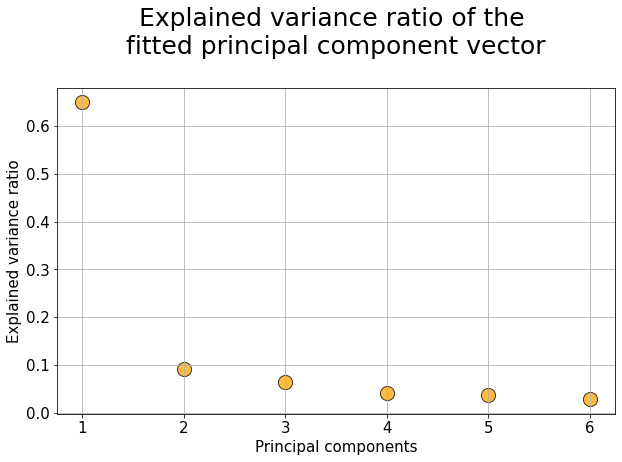

In [199]:
plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(df_scaled_pca.explained_variance_ratio_))],
            y=df_scaled_pca.explained_variance_ratio_,
            s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=25)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(df_scaled_pca.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.savefig("PCA.png")
plt.show()

End.

In [200]:
i = 1
for pca_component in df_scaled_pca.explained_variance_ratio_:
    if pca_component > 0.01:
        print("Component", i, "explains", round(pca_component * 100, 2), "%")
        i += 1

Component 1 explains 64.91 %
Component 2 explains 9.21 %
Component 3 explains 6.44 %
Component 4 explains 4.14 %
Component 5 explains 3.77 %
Component 6 explains 2.92 %


In [201]:
df_regr_pca = pca.transform(df_regr_scaled)

In [202]:
df_regr_pca[0:2]

array([[ 1.99457019,  4.30522952, 14.37359213, -2.17309472,  0.63737403,
        -1.37359127],
       [ 1.99457019,  4.30522952, 14.37359213, -2.17309472,  0.63737403,
        -1.37359127]])

In [203]:
df_regr_pca.shape

(54, 6)

***

### Step 3: Regression

### To Do:
**Paste together with categorical data to build data set for prediction**

In [204]:
df_regression = pd.DataFrame(df_regr_pca, columns=["PCA_1", "PCA_2", "PCA_3", "PCA_4", "PCA_5", "PCA_6"])

In [207]:
time_cluster_dummies = pd.get_dummies(df_regr['cluster'], prefix='cluster', drop_first=True)

I am not sure whether we should or should not drop one column for the dummies?

In [208]:
df_regression = pd.concat([df_regression, time_cluster_dummies], axis = 1)

In [209]:
df_regression.head(1)

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,cluster_off_peak,cluster_peak
0,1.99457,4.30523,14.373592,-2.173095,0.637374,-1.373591,0,0


### Linear Regression

In [210]:
from sklearn.linear_model import LinearRegression

In [211]:
X = df_regression

In [212]:
reg = LinearRegression().fit(X, y)

In [213]:
reg.score(X, y)

0.6596955866610159

In [214]:
reg.coef_

array([ 0.49269668, -0.24820024,  0.9383647 ,  0.30828919,  0.52471648,
       -0.29208551, -2.81401709, 10.80222222])

In [215]:
reg.intercept_

5.553333333333332

### Ridge Regression

In [216]:
from sklearn.linear_model import Ridge

In [217]:
ridge_reg = Ridge(alpha=0.5)

In [218]:
ridge_reg.fit(X, y)

Ridge(alpha=0.5)

In [219]:
ridge_reg.score(X, y)

0.6593671159314402

### SVR

In [220]:
from sklearn.svm import SVR

In [221]:
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_sigmoid = SVR(kernel='sigmoid', C=100, gamma="auto", epsilon=.1, coef0=1)
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1)

In [222]:
print(svr_rbf.fit(X, y))
print(svr_lin.fit(X, y))
print(svr_poly.fit(X, y))
print(svr_sigmoid.fit(X, y))

SVR(C=100, gamma=0.1)
SVR(C=100, gamma='auto', kernel='linear')
SVR(C=100, coef0=1, gamma='auto', kernel='poly')
SVR(C=100, coef0=1, gamma='auto', kernel='sigmoid')


In [223]:
print("RBF:", svr_rbf.score(X, y))
print("Lin:", svr_lin.score(X, y))
print("Poly", svr_poly.score(X, y))
print("Sigmoid", svr_sigmoid.score(X, y))

RBF: 0.9351216493214036
Lin: 0.6120579810480937
Poly 0.997251594446552
Sigmoid -4941.285496492263


***

## Setting up overall input with 3 hour time windows for regression

In [ ]:
# Create empty data frame of size [Days (~500)] * [Time windows (8)] * [Number of hex bins (18)] = 78840

In [ ]:
(78625 - 1) / (18 * 8)

In [ ]:
date_start = '2018-01-01'
date_end = '2019-07-01'
dates = pd.date_range(date_start, date_end, freq='3h')

In [ ]:
all_days_df = pd.DataFrame(dates, columns=["dates"])

In [ ]:
all_days_df.info()

In [ ]:
all_days_df.head()

In [ ]:
print("Number of all 3 hour time windows:", all_days_df.shape[0])

len_windows = all_days_df.shape[0]

list_bins_windows = []

for i in range(0, df_seg.shape[0]):
    list_bins_windows.append(len_windows * [df_seg["h3_zone_6"][i]])

In [ ]:
list_bins_windows_flat = np.array([list_bins_windows]).flatten()
len(list_bins_windows_flat)

In [ ]:
overall_df = all_days_df.copy()

for i in range(17):
    overall_df = overall_df.append(all_days_df, ignore_index=True)

In [ ]:
overall_df.shape

In [ ]:
overall_df["hex_bins"] = list_bins_windows_flat

In [ ]:
overall_df.head()

In [ ]:
print(overall_df.groupby("hex_bins").dates.count())
print("____________________________")
print("Number of bins:", len(overall_df.groupby("hex_bins").dates.count()))